In [1]:
!rm -rf /content/sample_data

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=6ee41f16620a507fa737b026e297f14617d5320d25c94a22373adcd6b12d3c65
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torchvision import models, transforms
import pickle
import os

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)

cuda


In [5]:
!mkdir -p /content/kaggle/input
%cd /content/kaggle/input

/content/kaggle/input


In [6]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle/input/"
os.environ['KAGGLE_USERNAME'] = "ehzawad"
os.environ['KAGGLE_KEY'] = "79f3db3d7153fcea7b7321ad6114c9dd"

In [7]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [01:44<00:00, 75.0MB/s]
100% 9.51G/9.51G [01:44<00:00, 97.6MB/s]


In [8]:
!unzip /content/kaggle/input/aptos2019-blindness-detection.zip -d /content/kaggle/input

Streaming output truncated to the last 5000 lines.
  inflating: /content/kaggle/input/test_images/512beaada8f0.png  
  inflating: /content/kaggle/input/test_images/51323e9d2070.png  
  inflating: /content/kaggle/input/test_images/515675001b9e.png  
  inflating: /content/kaggle/input/test_images/515877da2def.png  
  inflating: /content/kaggle/input/test_images/5168ddccea88.png  
  inflating: /content/kaggle/input/test_images/5172c056a687.png  
  inflating: /content/kaggle/input/test_images/5177461f5339.png  
  inflating: /content/kaggle/input/test_images/51910bcb980d.png  
  inflating: /content/kaggle/input/test_images/51a3e9b6a1c0.png  
  inflating: /content/kaggle/input/test_images/51bbd82feec8.png  
  inflating: /content/kaggle/input/test_images/51de5fb8eccd.png  
  inflating: /content/kaggle/input/test_images/51e88694c81f.png  
  inflating: /content/kaggle/input/test_images/51f0bf8f1544.png  
  inflating: /content/kaggle/input/test_images/51f57fb32840.png  
  inflating: /content/kag

In [9]:
path = "/content/kaggle/input/"

train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


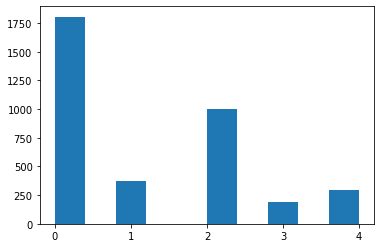

In [10]:
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [11]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4]), y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
 
print(class_weights) 

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


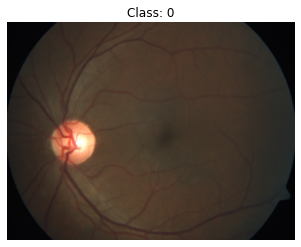

In [12]:
num = int(np.random.randint(0, len(train_df)-1, (1, )))
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}')
plt.show()

In [13]:
class dataset(Dataset):     
    def __init__(self, df, data_path, image_transform=None, train=True): 
        super(Dataset,self).__init__() 
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') 
        if self.image_transform :
            image = self.image_transform(image) 
        
        if self.train :
            label = self.df['diagnosis'][index]
            return image, label 
        
        else:
            return image 
            

In [14]:
image_transform = transforms.Compose([transforms.Resize([512, 512]),
                                      transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
data_set = dataset(train_df, f'{path}train_images', image_transform=image_transform)
train_set, valid_set = torch.utils.data.random_split(data_set, [3302,360])

In [15]:
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True) 
valid_dataloader = DataLoader(valid_set, batch_size=32, shuffle=True)

In [16]:
# len(train_dataloader.dataset.indices)
len(valid_dataloader.dataset.indices)

360

In [17]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=10):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # Remove last linear layer
        self.modelA.fc = nn.Linear(512, nb_classes)

        # self.modelB.classifier = nn.Linear(1024, nb_classes)
        self.modelB.classifier[6] = nn.Linear(4096, nb_classes)

        # Create new classifier
        self.classifier = nn.Linear(10, nb_classes)

    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)

        x = self.classifier(F.relu(x))
        return x


modelA = models.resnet18(pretrained=True)
# modelB = models.densenet121(pretrained=True)
modelB = models.vgg16(pretrained=True)

# Freeze these models
for param in modelA.parameters():
    param.requires_grad_(False)

for param in modelB.parameters():
    param.requires_grad_(False)

# Create ensemble model
model = MyEnsemble(modelA, modelB, 5)
# x = torch.randn(1, 3, 224, 224)
# output = model(x)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [18]:
import torch.nn.utils.prune as prune

In [19]:
model = model.to(device)

In [20]:
def pruning(proportion):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=proportion)
            # If you want to remove a module, just assign a module to a variable r and then call prune.remove(r)
        elif isinstance(module, torch.nn.Conv1d):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.BatchNorm2d):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.BatchNorm1d):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.CrossEntropyLoss):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.Flatten):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.InstanceNorm1d):
            prune.l1_unstructured(module, name='weight', amount=proportion)

In [21]:
pruning(.1)

In [22]:
print(list(model.named_buffers()))

[('modelA.conv1.weight_mask', tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1

In [23]:
model = model.to(device)

In [24]:
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [25]:
def measure_global_sparsity(model,
                            weight=True,
                            bias=True,
                            conv2d_use_mask=True,
                            conv1d_use_mask=True,
                            linear_use_mask=True,
                            batchnorm1_use_mask=True,
                            batchnorm2_use_mask=True,
                            crossEntropy_use_mask=True,
                            flatten_use_mask=True,
                            instanceNorm1_use_mask=True): 
    num_zeros = 0
    num_elements = 0



    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Conv1d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv1d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.BatchNorm1d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=batchnorm1_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.BatchNorm2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=batchnorm2_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements



        elif isinstance(module, torch.nn.CrossEntropyLoss):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=crossEntropy_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements


        elif isinstance(module, torch.nn.Flatten):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=flatten_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

     
        elif isinstance(module, torch.nn.InstanceNorm1d):
            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=instanceNorm1_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements
    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [26]:
num_zeros, num_elements, sparsity = measure_global_sparsity(
            model,
            weight=True,
            bias=True,
            conv2d_use_mask=True,
            conv1d_use_mask=True,
            linear_use_mask=True,
            batchnorm1_use_mask=True,
            batchnorm2_use_mask=True,
            crossEntropy_use_mask=True,
            flatten_use_mask=True,
            instanceNorm1_use_mask=True)
 



In [27]:
print(num_zeros)
print(num_elements)
print(sparsity)

14544295
145442930
0.10000001375109811


In [28]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total = 0
    correct = 0
    running_loss = 0
    trainingAccuracy = 0
    
    for batch in tqdm(dataloader):       
        x = batch[0]
        y = batch[1]
        output = model(x.to(device)) 
        loss   = loss_fn(output, y.to(device))
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach()
        correct      += (predictions == y.cpu().detach()).sum().item()

        
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
             
    
    avg_loss = running_loss/len(dataloader)

    training_accuracy = 100*(correct/total)

    print(f'\nTraining Loss = {avg_loss:.6f}', end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]')
    
    return avg_loss, training_accuracy

In [29]:
def validate(dataloader,model,loss_fn): 
    model.eval()     
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad():  
        for x,y in dataloader:
            
            output        = model(x.to(device)) 
            loss          = loss_fn(output, y.to(device)).item()
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader)     
    validation_accuracy = 100*(correct/total)

    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]')
      
    return avg_loss, validation_accuracy

In [30]:
def optimize(train_dataloader, valid_dataloader, model, loss_fn, optimizer, nb_epochs):
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []
    best_valid_acc = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss, train_accuracy = train(train_dataloader, model, loss_fn ,optimizer)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)
        valid_loss, validation_accuracy = validate(valid_dataloader, model, loss_fn)
        valid_losses.append(valid_loss)
        valid_acc.append(validation_accuracy)

       
    
    print('\nunstructed_pruning_for_sparsity Training has completed!')
    return train_losses, valid_losses, train_acc, valid_acc

In [ ]:
from tqdm.notebook import tqdm
loss_fn   = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) 
nb_epochs = 20

train_losses, valid_losses, train_acc, valid_acc = optimize(train_dataloader, valid_dataloader, model, loss_fn, optimizer, nb_epochs)


Epoch 1/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Training Loss = 1.565980	Accuracy on Training set = 41.429437% [1368/3302]

Validation Loss = 1.487170	Accuracy on Validation set = 52.222222% [188/360]

Epoch 2/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.446558	Accuracy on Training set = 57.298607% [1892/3302]

Validation Loss = 1.385244	Accuracy on Validation set = 57.500000% [207/360]

Epoch 3/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.354591	Accuracy on Training set = 61.992732% [2047/3302]

Validation Loss = 1.316011	Accuracy on Validation set = 64.166667% [231/360]

Epoch 4/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.293149	Accuracy on Training set = 65.505754% [2163/3302]

Validation Loss = 1.275002	Accuracy on Validation set = 68.333333% [246/360]

Epoch 5/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

In [ ]:
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('unstructed_Pruned_Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("unstructed_pruned_Training and validation.png")
plt.show()

In [ ]:
epochs = range(nb_epochs)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, valid_acc, 'b', label='validation accuracy')
plt.title('unstructed_pruning_for_Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("unstructed_pruning_for_traning_validation_ACCURACY.png")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support

def luate(dataloader,model_pass,loss_fn): 
    model_pass.eval()     
    total = 0
    correct = 0
    running_loss = 0
    actual_label_list = []
    predicted_label_list = []

    with torch.no_grad():  
        for x,y in dataloader:
            
            output        = model_pass(x.to(device)) 
            loss          = loss_fn(output, y.to(device)).item()
            running_loss += loss
          
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()

            actual_label_list.append(y.cpu().detach().tolist())
            predicted_label_list.append(predictions.tolist())
            
    avg_loss = running_loss/len(dataloader)     
    validation_accuracy = 100*(correct/total)

    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]')

    actual_labels = [item for sublist in actual_label_list  for item in sublist]
    predicted_labels = [item for sublist in predicted_label_list  for item in sublist]

    acc = accuracy_score(actual_labels, predicted_labels)
    p, r, f1, _ = precision_recall_fscore_support(actual_labels,  predicted_labels, average='macro')
    kappa = cohen_kappa_score(actual_labels, predicted_labels)

    # print('Acc: ' + str(acc*100)+'%')
    # print('Precision: ' + str(p*100)+'%')
    # print('Recall: ' + str(r*100)+'%')
    # print('F1 score: ' + str(f1*100)+'%')
    # print('Kappa score: ' + str(kappa*100)+'%')

    return avg_loss

def prune_model(model_pass, layer_type, proportion):
    for name, module in model_pass.named_modules():
        if isinstance(module, layer_type):
            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')
    return model_pass

def prune_model_l1_unstructured(model_pass, layer_type, proportion):
    for module in model_pass.modules():
        if isinstance(module, layer_type):
            prune.l1_unstructured(module, 'weight', proportion)
            # prune.remove(module, 'weight')
    return model_pass

def test_pruning_jobs(model_pass, prune_fn, eval_fn):
    losses = []
    
    print(f"Evaluating model with θ=0 pruning.")
    
    unpruned_loss = luate(valid_dataloader, model_pass, loss_fn)
    losses.append((0, unpruned_loss))
    
    for i in range(1, 18):
        p = i * 0.05
        print(f"Evaluating model with θ={p} pruning.")
   
        pruned_model = prune_fn(model_pass, p)
        loss = luate(valid_dataloader, pruned_model, loss_fn)
        losses.append((p, loss))
    
    return losses


In [ ]:
model_picked_for_unstructured_pruning = model
model_picked_for_structured_pruning = model
model_picked_for_global_unstructured_pruning = model


In [ ]:
if model_picked_for_global_unstructured_pruning == model_picked_for_structured_pruning:
  print('yes')

In [ ]:
if model_picked_for_structured_pruning == model_picked_for_global_unstructured_pruning:
  print('yes')

In [ ]:
prune_fn = lambda model_picked_for_unstructured_pruning, proportion: prune_model(model_picked_for_unstructured_pruning, nn.Conv2d, proportion)

losses = test_pruning_jobs(model_picked_for_unstructured_pruning, prune_fn, luate)
print(losses)

In [ ]:
pd.DataFrame.assign

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

import pandas as pd
(pd.DataFrame(losses, columns=['sparsity', 'loss'])
 .pipe(lambda df: df.assign(
     perf=(df.loss - pd.Series([losses[0][1]] * len(df))) / losses[0][1] + 1
 ))
 .head(15)
 .plot.line(x='sparsity', y='perf', figsize=(12, 8), title="L1 Unstructured Pruned Mean Batch Loss").figure.savefig('L1 Unstructured Pruned Mean Batch Loss.png')
)
sns.despine()


In [ ]:
def prune_model_l1_structured(model, layer_type, proportion):
    """
    Prunes the model.
    """
    for name, module in model.named_modules():
        if isinstance(module, layer_type):
            prune.ln_structured(module, 'weight', proportion, n=1, dim=1)
            prune.remove(module, 'weight')
    return model

prune_fn = lambda model_picked_for_structured_pruning, proportion: prune_model_l1_structured(model_picked_for_structured_pruning, nn.Conv2d, proportion)


In [ ]:
%%time
losses = test_pruning_jobs(model_picked_for_structured_pruning, prune_fn, luate)
print(losses)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

import pandas as pd
(pd.DataFrame(losses, columns=['sparsity', 'loss'])
 .pipe(lambda df: df.assign(
     perf=(df.loss - pd.Series([losses[0][1]] * len(df))) / losses[0][1] + 1
 ))
 .head(10)
 .plot.line(x='sparsity', y='perf', figsize=(12, 8), title="L1 Structured Pruned Mean Batch Loss").figure.savefig('L1 Structured Pruned Mean Batch Loss.png')
)
sns.despine()

In [ ]:
def prune_model_global_unstructured(model, layer_type, proportion):
    module_tups = []
    for module in model.modules():
        if isinstance(module, layer_type):
            module_tups.append((module, 'weight'))

    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    for module, _ in module_tups:
        prune.remove(module, 'weight')
    return model

prune_fn = lambda model_picked_for_global_unstructured_pruning, proportion: prune_model_global_unstructured(model_picked_for_unstructured_pruning, nn.Conv2d, proportion)


In [ ]:
%%time
losses = losses = test_pruning_jobs(model_picked_for_global_unstructured_pruning, prune_fn, luate)
print(losses)
